**LIBRARIES REQUIRED**

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import skimage
from skimage import transform
from torchvision import transforms
import torchvision
import matplotlib.pyplot as plt
import os
from google.colab import files

**CONVOLUTION LAYER**

In [0]:
class Unet_conv(nn.Module):
  
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Unet_conv,self).__init__()
    
    self.conv=nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel,stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU()
#           nn.Conv2d(out_channel,out_channel,kernel,stride),
#           nn.BatchNorm2d(out_channel),
#           nn.ReLU()
        )
  
  def forward(self, x):
    x=self.conv(x)
    
#     print('conv')
#     print(x.shape)
#     plt.imshow(x[0][0].detach().numpy())
#     plt.show()
        
    return(x)
  
  

**DOWNSAMPLE LAYER**

In [0]:
class Unet_downsample(nn.Module):
  def __init__(self,kernel_size,stride):
    super(Unet_downsample,self).__init__()
    self.kernel_size=kernel_size
    self.stride=stride
  def forward(self, x):
   
    max_pooled=F.max_pool2d(x,kernel_size=self.kernel_size,stride=self.stride)
#     print('max') 
#     print(max_pooled.shape)
#     plt.imshow(max_pooled[0][0].detach().numpy())
#     plt.show()
    
    return(max_pooled)
  
  

**DECONV LAYER**

In [0]:
class Unet_deconv(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Unet_deconv,self).__init__()
    self.upsample=nn.Sequential(
#           nn.Conv2d(in_channel,out_channel,kernel,stride),
#           nn.BatchNorm2d(out_channel),
#           nn.ReLU(),  
            nn.ConvTranspose2d(in_channel,out_channel,kernel, stride),
            nn.BatchNorm2d(out_channel),
            nn.ReLU()
        )
     
  def forward(self, x):
    x=self.upsample(x)
#     print('upsample') 
#     print(x.shape)
#     plt.imshow(x[0][0].detach().numpy())
#     plt.show()
    
    return(x)
  
  

**UPSAMPLE LAYER**

In [0]:
class Unet_upsample(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Unet_upsample,self).__init__()
    self.upsample=nn.Sequential(
          nn.Upsample(scale_factor=2, mode='nearest'),

          nn.Conv2d(in_channel,out_channel,kernel,stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU()
    )
            
     
  def forward(self, x):
#     x=F.interpolate(x,scale_factor=2, mode='nearest')
    x=self.upsample(x)
#     print('upsample') 
#     print(x.shape)
#     plt.imshow(x[0][0].detach().numpy())
#     plt.show()
    
    return(x)
  
  

**CROP-CONCAT LAYER**

In [0]:
def center_crop(layer, target_size):
    batch_size, n_channels, layer_width, layer_height = layer.size()
    xy1 = (layer_width - target_size) // 2
    return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

def concatenate(down_layer,up_layer):
    new_layer=torch.cat((up_layer,down_layer),1)
    return new_layer

**DROP-OUT LAYER**

In [0]:
class Unet_drop(nn.Module):
  def __init__(self,prob,out_channel):
    super(Unet_drop,self).__init__()
    self.droped=nn.Sequential(
         nn.Dropout2d(p=prob),
         nn.BatchNorm2d(out_channel),
         nn.ReLU()
         )
  
  
  def forward(self, x):
    x=self.droped(x)
#     print('dropped') 
#     print(x.shape)
#     plt.imshow(x[0][0].detach().numpy())
#     plt.show()
    
    return(x)
  
  

**FINAL CONVOLUTION LAYER**

In [0]:
class Unet_final(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Unet_final,self).__init__()
    self.final=nn.Sequential(
          nn.Conv2d(in_channel,out_channel,kernel,stride),
          nn.BatchNorm2d(out_channel),
          nn.ReLU(),
          
        )

  def forward(self, x):
    x=self.final(x)
#     print('final') 
#     print(x.shape)
#     plt.imshow(x[0][0].detach().numpy())
#     plt.show()
    return(x)
  
  

# **Combining Components of U-Net**

In [0]:
class Original_Unet(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Original_Unet,self).__init__()
    self.l1=Unet_conv(in_channel,out_channel,kernel,stride)
    self.l2=Unet_conv(out_channel,out_channel*2,kernel,stride)
    self.l3=Unet_conv(out_channel*2,out_channel*4,kernel,stride)    
    self.l4=Unet_conv(out_channel*4,out_channel*8,kernel,stride)    
    self.l5=Unet_conv(out_channel*8,out_channel*16,kernel,stride)
    self.down=Unet_downsample(2,2)
    self.drop=Unet_drop(0.5,out_channel*16)
    
    self.up1=Unet_deconv(out_channel*16,out_channel*8,2,2)
    self.r5=Unet_conv(out_channel*16,out_channel*8,kernel,stride)
    
    self.up2=Unet_deconv(out_channel*8,out_channel*4,2,2)
    self.r4=Unet_conv(out_channel*8,out_channel*4,kernel,stride)
    
    self.up3=Unet_deconv(out_channel*4,out_channel*2,2,2)
    self.r3=Unet_conv(out_channel*4,out_channel*2,kernel,stride)
    
    self.up4=Unet_deconv(out_channel*2,out_channel,2,2)
    self.r2=Unet_conv(out_channel*2,out_channel,kernel,stride)
  
    self.final=Unet_final(out_channel,1,5,1)
    self.final1=Unet_final(4,in_channel,1,2)
#     self.up4=Unet_upsample(out_channel*16,out_channel*8,1,1)

  def forward(self, x):
    l1_1=self.l1(x)
    l1_max=self.down(l1_1)
    
    l2_1=self.l2(l1_max)
    l2_max=self.down(l2_1)
    
    l3_1=self.l3(l2_max)
    l3_max=self.down(l3_1)
    
    l4_1=self.l4(l3_max)
    l4_max=self.down(l4_1)
    
    l5_1=self.l5(l4_max)
    l5_drop=self.drop(l5_1)
    
    u5_1=self.up1(l5_drop)
    l4_1=center_crop(l4_1,u5_1.size()[2])
    u5_1=concatenate(l4_1,u5_1)
    
    r5_1=self.r5(u5_1)
    
    u4_1=self.up2(r5_1)
    l3_1=center_crop(l3_1,u4_1.size()[2])
    u4_1=concatenate(l3_1,u4_1)

    r4_1=self.r4(u4_1)
    
    u3_1=self.up3(r4_1)
    l2_1=center_crop(l2_1,u3_1.size()[2])
    u3_1=concatenate(l2_1,u3_1)
    
    r3_1=self.r3(u3_1)
    
    u2_1=self.up4(r3_1)
    l1_1=center_crop(l1_1,u2_1.size()[2])
    u2_1=concatenate(l1_1,u2_1)
    
    r2_1=self.r2(u2_1)
    
    last=self.final(r2_1)
    x=center_crop(x,last.size()[2])
    last=concatenate(x,last)
    
    last=self.final1(last)
    return(last)


In [0]:
class All_dropout(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(All_dropout,self).__init__()
    self.l1=Unet_conv(in_channel,out_channel,kernel,stride)
    self.drop1=Unet_drop(0.1,out_channel)
    
    self.l2=Unet_conv(out_channel,out_channel*2,kernel,stride)
    self.drop2=Unet_drop(0.1,out_channel*2)
    
    self.l3=Unet_conv(out_channel*2,out_channel*4,kernel,stride)    
    self.drop3=Unet_drop(0.1,out_channel*4)
    
    self.l4=Unet_conv(out_channel*4,out_channel*8,kernel,stride)    
    self.drop4=Unet_drop(0.1,out_channel*8)
    
    self.l5=Unet_conv(out_channel*8,out_channel*16,kernel,stride)
    self.drop5=Unet_drop(0.1,out_channel*16)
    
    self.down=Unet_downsample(2,2)
    
    
    self.up1=Unet_upsample(out_channel*16,out_channel*8,1,1)
    self.r5=Unet_conv(out_channel*16,out_channel*8,kernel,stride)
    self.drop6=Unet_drop(0.1,out_channel*8)

    self.up2=Unet_upsample(out_channel*8,out_channel*4,1,1)
    self.r4=Unet_conv(out_channel*8,out_channel*4,kernel,stride)
    self.drop7=Unet_drop(0.1,out_channel*4)

    self.up3=Unet_upsample(out_channel*4,out_channel*2,1,1)
    self.r3=Unet_conv(out_channel*4,out_channel*2,kernel,stride)
    self.drop8=Unet_drop(0.1,out_channel*2)

    self.up4=Unet_upsample(out_channel*2,out_channel,1,1)
    
    self.r2=Unet_conv(out_channel*2,out_channel,kernel,stride)
    self.drop9=Unet_drop(0.1,out_channel)

    self.final=Unet_final(out_channel,1,5,1)
    self.final1=Unet_final(4,in_channel,1,1)

    
  def forward(self, x):
    l1_1=self.l1(x)
    l1_1=self.drop1(l1_1)
    l1_max=self.down(l1_1)
    
    l2_1=self.l2(l1_max)
    l2_1=self.drop2(l2_1)
    l2_max=self.down(l2_1)
    
    l3_1=self.l3(l2_max)
    l3_1=self.drop3(l3_1)
    l3_max=self.down(l3_1)
    
    l4_1=self.l4(l3_max)
    l4_1-self.drop4(l4_1)
    l4_max=self.down(l4_1)
    
    l5_1=self.l5(l4_max)
    l5_drop=self.drop5(l5_1)
    
    u5_1=self.up1(l5_drop)
    l4_1=center_crop(l4_1,u5_1.size()[2])
    u5_1=concatenate(l4_1,u5_1)
    
    r5_1=self.r5(u5_1)
    r5_1=self.drop6(r5_1)

    u4_1=self.up2(r5_1)
    l3_1=center_crop(l3_1,u4_1.size()[2])
    u4_1=concatenate(l3_1,u4_1)

    r4_1=self.r4(u4_1)
    r4_1=self.drop7(r4_1)

    u3_1=self.up3(r4_1)
    l2_1=center_crop(l2_1,u3_1.size()[2])
    u3_1=concatenate(l2_1,u3_1)
    
    r3_1=self.r3(u3_1)
    r3_1=self.drop8(r3_1)

    u2_1=self.up4(r3_1)
    l1_1=center_crop(l1_1,u2_1.size()[2])
    u2_1=concatenate(l1_1,u2_1)
    
    r2_1=self.r2(u2_1)
    r2_1=self.drop9(r2_1)

    last=self.final(r2_1)
    x=center_crop(x,last.size()[2])
    last=concatenate(x,last)
    
    last=self.final1(last)
    return(last)


In [0]:
class All_convolution(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(All_convolution,self).__init__()
    self.l1_1=Unet_conv(in_channel,out_channel,kernel,stride)
    self.l1_2=Unet_conv(out_channel,out_channel,2,2)
    self.drop1=Unet_drop(0.1,out_channel)
    
    self.l2_1=Unet_conv(out_channel,out_channel*2,kernel,stride)
    self.l2_2=Unet_conv(out_channel*2,out_channel*2,2,2)
    self.drop2=Unet_drop(0.1,out_channel*2)
    
    self.l3_1=Unet_conv(out_channel*2,out_channel*4,kernel,stride)    
    self.l3_2=Unet_conv(out_channel*4,out_channel*4,2,2)    

    self.drop3=Unet_drop(0.1,out_channel*4)
    
    self.l4_1=Unet_conv(out_channel*4,out_channel*8,kernel,stride)    
    self.l4_2=Unet_conv(out_channel*8,out_channel*8,2,2)    
    self.drop4=Unet_drop(0.1,out_channel*8)
    
    self.l5=Unet_conv(out_channel*8,out_channel*16,kernel,stride)
    self.drop5=Unet_drop(0.1,out_channel*16)
        
    
    self.up1=Unet_upsample(out_channel*16,out_channel*8,1,1)
    self.r5=Unet_conv(out_channel*16,out_channel*8,kernel,stride)
    self.drop6=Unet_drop(0.1,out_channel*8)

    self.up2=Unet_upsample(out_channel*8,out_channel*4,1,1)
    self.r4=Unet_conv(out_channel*8,out_channel*4,kernel,stride)
    self.drop7=Unet_drop(0.1,out_channel*4)

    self.up3=Unet_upsample(out_channel*4,out_channel*2,1,1)
    self.r3=Unet_conv(out_channel*4,out_channel*2,kernel,stride)
    self.drop8=Unet_drop(0.1,out_channel*2)

    self.up4=Unet_upsample(out_channel*2,out_channel,1,1)
    
    self.r2=Unet_conv(out_channel*2,out_channel,kernel,stride)
    self.drop9=Unet_drop(0.1,out_channel)

    self.final=Unet_final(out_channel,1,5,1)
    self.final1=Unet_final(4,in_channel,1,1)

    
  def forward(self, x):
    l1_1=self.l1_1(x)
    l1_1=self.drop1(l1_1)
    l1_2=self.l1_2(l1_1)
    
    l2_1=self.l2_1(l1_2)
    l2_1=self.drop2(l2_1)
    l2_2=self.l2_2(l2_1)
    
    l3_1=self.l3_1(l2_2)
    l3_1=self.drop3(l3_1)
    l3_2=self.l3_2(l3_1)
    
    l4_1=self.l4_1(l3_2)
    l4_1-self.drop4(l4_1)
    l4_2=self.l4_2(l4_1)
    
    l5_1=self.l5(l4_2)
    l5_drop=self.drop5(l5_1)
    
    u5_1=self.up1(l5_drop)
    l4_1=center_crop(l4_1,u5_1.size()[2])
    u5_1=concatenate(l4_1,u5_1)
    
    r5_1=self.r5(u5_1)
    r5_1=self.drop6(r5_1)

    u4_1=self.up2(r5_1)
    l3_1=center_crop(l3_1,u4_1.size()[2])
    u4_1=concatenate(l3_1,u4_1)

    r4_1=self.r4(u4_1)
    r4_1=self.drop7(r4_1)

    u3_1=self.up3(r4_1)
    l2_1=center_crop(l2_1,u3_1.size()[2])
    u3_1=concatenate(l2_1,u3_1)
    
    r3_1=self.r3(u3_1)
    r3_1=self.drop8(r3_1)

    u2_1=self.up4(r3_1)
    l1_1=center_crop(l1_1,u2_1.size()[2])
    u2_1=concatenate(l1_1,u2_1)
    
    r2_1=self.r2(u2_1)
    r2_1=self.drop9(r2_1)

    last=self.final(r2_1)
    x=center_crop(x,last.size()[2])
    last=concatenate(x,last)
    last=self.final1(last)
    return(last)


In [0]:
class Inverted_Net(nn.Module):
  def __init__(self,in_channel,out_channel,kernel,stride):
    super(Inverted_Net,self).__init__()
    self.l1_1=Unet_conv(in_channel,out_channel,kernel,stride)
    self.drop1=Unet_drop(0.1,out_channel)
    
    self.l2_1=Unet_conv(out_channel,out_channel//2,kernel,stride)
    self.drop2=Unet_drop(0.1,out_channel//2)
    
    self.l3_1=Unet_conv(out_channel//2,out_channel//4,kernel,stride=2)    
    self.drop3=Unet_drop(0.1,out_channel//4)
    
    self.l4_1=Unet_conv(out_channel//4,out_channel//8,kernel,stride=2)    
    self.drop4=Unet_drop(0.1,out_channel//8)
    
    self.l5=Unet_conv(out_channel//8,out_channel//16,kernel,stride=2)
    self.drop5=Unet_drop(0.1,out_channel//16)
        
    self.down=Unet_downsample(2,1)
    
    self.up1=Unet_upsample(out_channel//16,out_channel//8,1,1)
    self.r5=Unet_conv(out_channel//4,out_channel//8,kernel,stride)
    self.drop6=Unet_drop(0.1,out_channel//8)

    self.up2=Unet_upsample(out_channel//8,out_channel//4,1,1)
    self.r4=Unet_conv(out_channel//2,out_channel//4,kernel,stride)
    self.drop7=Unet_drop(0.1,out_channel//4)

    self.up3=Unet_upsample(out_channel//4,out_channel//2,1,1)
    self.r3=Unet_conv(out_channel,out_channel//2,kernel,stride)
    self.drop8=Unet_drop(0.1,out_channel//2)

#     self.up4=Unet_upsample(out_channel//2,out_channel,1,1)
    
    self.r2=Unet_conv(out_channel//2,out_channel,kernel,stride)
    self.drop9=Unet_drop(0.1,out_channel)

    self.final=Unet_final(out_channel,1,4,1)
    self.final1=Unet_final(4,in_channel,1,1)

    
  def forward(self, x):
    l1_1=self.l1_1(x)
    l1_1=self.drop1(l1_1)
    l1_2=self.down(l1_1)
    
    l2_1=self.l2_1(l1_2)
    l2_1=self.drop2(l2_1)
    l2_2=self.down(l2_1)
    
    l3_1=self.l3_1(l2_2)
    l3_1=self.drop3(l3_1)
    l3_2=self.down(l3_1)
    
    l4_1=self.l4_1(l3_2)
    l4_1=self.drop4(l4_1)
    l4_2=self.down(l4_1)
    
    l5_1=self.l5(l4_2)
    l5_drop=self.drop5(l5_1)
    
    
    u5_1=self.up1(l5_drop)
    l4_1=center_crop(l4_1,u5_1.size()[2])
    u5_1=concatenate(l4_1,u5_1)
    
    r5_1=self.r5(u5_1)
    r5_1=self.drop6(r5_1)
    
    

    u4_1=self.up2(r5_1)
    l3_1=center_crop(l3_1,u4_1.size()[2])
    u4_1=concatenate(l3_1,u4_1)

    r4_1=self.r4(u4_1)
    r4_1=self.drop7(r4_1)

    u3_1=self.up3(r4_1)
    l2_1=center_crop(l2_1,u3_1.size()[2])
    u3_1=concatenate(l2_1,u3_1)
    
    r3_1=self.r3(u3_1)
    r3_1=self.drop8(r3_1)

#     u2_1=self.up4(r3_1)
#     u2_1=center_crop(u2_1,l1_1.size()[2])
#     u2_1=concatenate(l1_1,u2_1)
    
    r2_1=self.r2(r3_1)
    r2_1=self.drop9(r2_1)

    last=self.final(r2_1)
#     x=center_crop(x,last.size()[2])
#     last=concatenate(x,last)
    
#     last=self.final1(last)
    
    return(last)


In [0]:
model1=Original_Unet(3,64,3,1)
# print(model1)

In [0]:
model2=All_dropout(3,64,3,1)
# print(model2)

In [0]:
model3=All_convolution(3,64,3,1)
# print(model2)

In [0]:
model4=Inverted_Net(3,256,3,1)
# print(model2)

In [17]:
transform = transforms.Compose(
    [transforms.ToTensor()])
test_set2=torchvision.datasets.ImageFolder('/content/test/images',transform = transform)

test_loader2 = torch.utils.data.DataLoader(test_set2,
                                          batch_size=1,
                                          shuffle=True,
                                          num_workers=0)
len(test_loader2)

15

In [18]:
!ls

CN0.jpg  img2.jpg  img3.jpg  sample_data  test


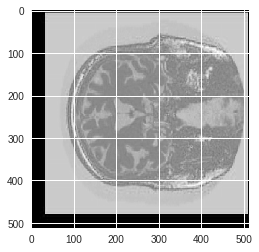

tensor([2])


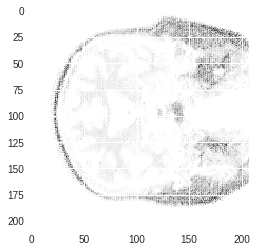

torch.Size([1, 3, 207, 207])


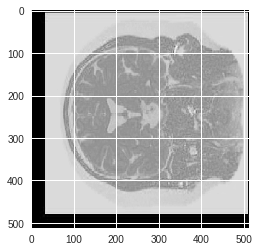

tensor([2])


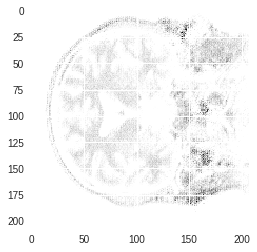

torch.Size([1, 3, 207, 207])


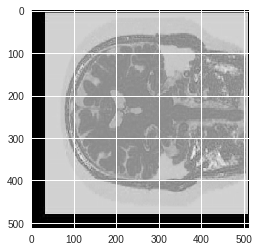

tensor([1])


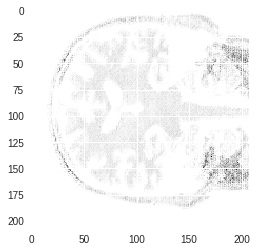

torch.Size([1, 3, 207, 207])


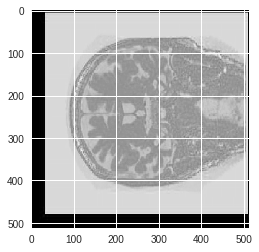

tensor([0])


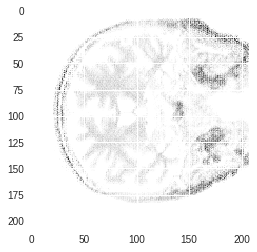

torch.Size([1, 3, 207, 207])


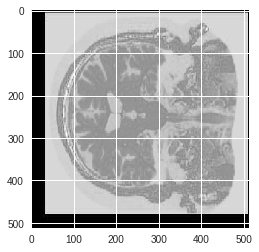

tensor([0])


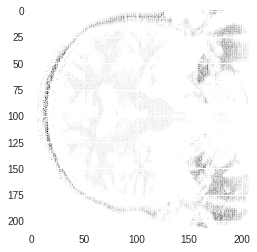

torch.Size([1, 3, 207, 207])


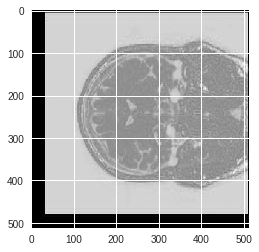

tensor([0])


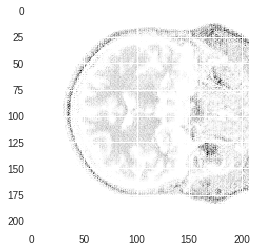

torch.Size([1, 3, 207, 207])


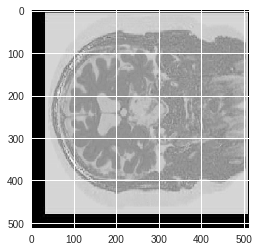

tensor([2])


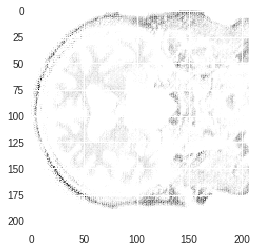

torch.Size([1, 3, 207, 207])


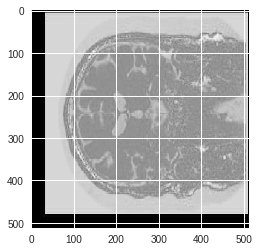

tensor([2])


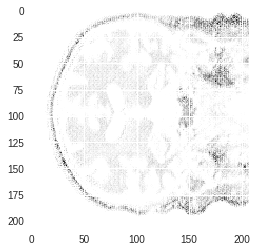

torch.Size([1, 3, 207, 207])


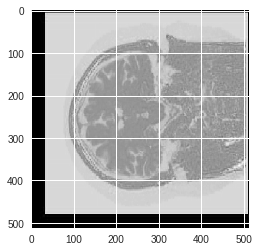

tensor([2])


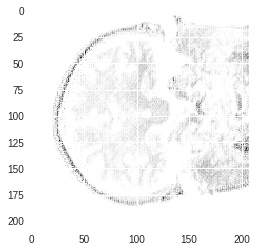

torch.Size([1, 3, 207, 207])


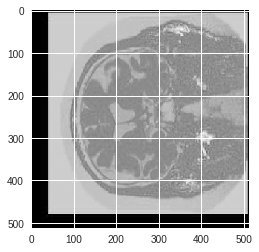

tensor([0])


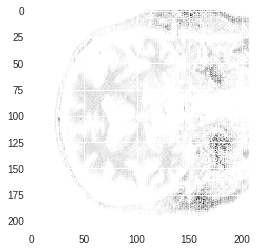

torch.Size([1, 3, 207, 207])


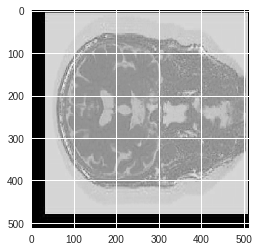

tensor([1])


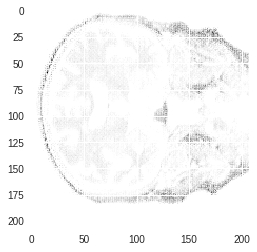

torch.Size([1, 3, 207, 207])


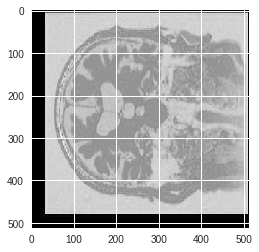

tensor([0])


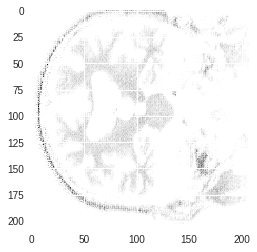

torch.Size([1, 3, 207, 207])


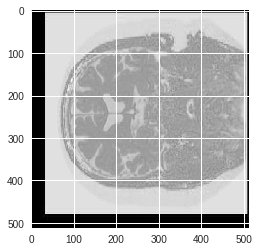

tensor([1])


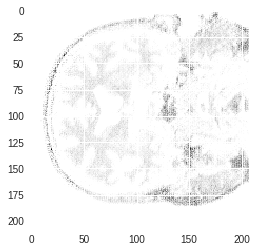

torch.Size([1, 3, 207, 207])


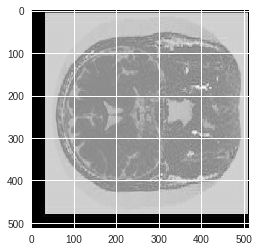

tensor([1])


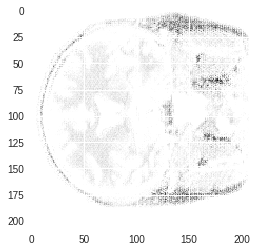

torch.Size([1, 3, 207, 207])


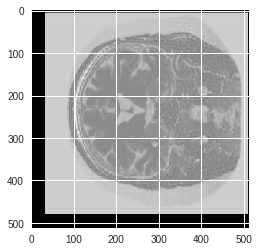

tensor([1])


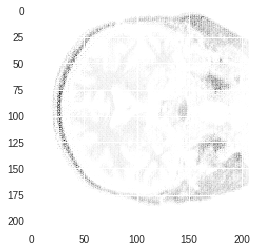

torch.Size([1, 3, 207, 207])


In [45]:
import matplotlib.pyplot as plt
%matplotlib inline
AD=0
CN=0
MCI=0

for images, labels in test_loader2:
    plt.imshow(images[0][2])
    plt.show()
    out=model1(images)
    print(labels)
    plt.imshow(out[0][0].detach().numpy())
    plt.show()
    print(out.shape)
    
#     if(labels.item()==0):
#       plt.imsave("AD"+str(AD)+".jpg",out[0][0].detach().numpy())
#       AD+=1
#     if(labels.item()==1):
#       plt.imsave("CN"+str(CN)+".jpg",out[0][0].detach().numpy())
#       CN+=1 
#     if(labels.item()==2):
#       plt.imsave("MCI"+str(MCI)+".jpg",out[0][0].detach().numpy())
#       MCI+=1
      
    
    

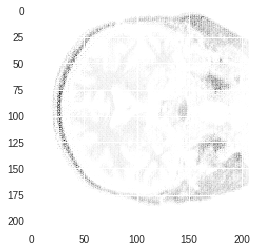

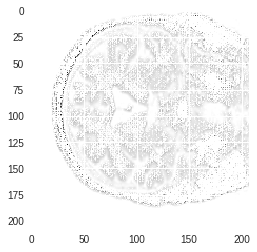

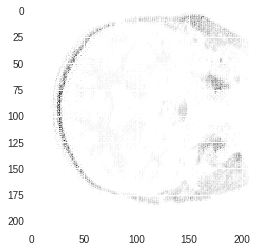

(<matplotlib.image.AxesImage at 0x7f35c0b4a080>, None)

In [46]:
plt.imshow(out[0][0].detach().numpy()), plt.show()
plt.imshow(out[0][1].detach().numpy()), plt.show()
plt.imshow(out[0][2].detach().numpy()), plt.show()


In [0]:
plt.imshow(out4[0][0].detach().numpy()), plt.show()
plt.imshow(out4[0][1].detach().numpy()), plt.show()
plt.imshow(out4[0][2].detach().numpy()), plt.show()
plt.imshow(out4[0][3].detach().numpy()), plt.show()
  

In [42]:
for i in range(0,5):
  files.download('MCI'+str(i)+'.jpg')
!ls

AD0.jpg  AD3.jpg  CN1.jpg  CN4.jpg   MCI0.jpg  MCI3.jpg     test
AD1.jpg  AD4.jpg  CN2.jpg  img2.jpg  MCI1.jpg  MCI4.jpg
AD2.jpg  CN0.jpg  CN3.jpg  img3.jpg  MCI2.jpg  sample_data


usage: git [--version] [--help] [-C <path>] [-c name=value]
           [--exec-path[=<path>]] [--html-path] [--man-path] [--info-path]
           [-p | --paginate | --no-pager] [--no-replace-objects] [--bare]
           [--git-dir=<path>] [--work-tree=<path>] [--namespace=<name>]
           <command> [<args>]

These are common Git commands used in various situations:

start a working area (see also: git help tutorial)
   clone      Clone a repository into a new directory
   init       Create an empty Git repository or reinitialize an existing one

work on the current change (see also: git help everyday)
   add        Add file contents to the index
   mv         Move or rename a file, a directory, or a symlink
   reset      Reset current HEAD to the specified state
   rm         Remove files from the working tree and from the index

examine the history and state (see also: git help revisions)
   bisect     Use binary search to find the commit that introduced a bug
   grep       Print li

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 1 output channels, 3x3 square convolution kernel
        
        self.conv1 = nn.Conv2d(3, 64, 3)
        print("conv1")
        self.conv2 = nn.Conv2d(64,64, 3)
        self.conv3 = nn.Conv2d(64,128, 3)
        self.conv4 = nn.Conv2d(128,128, 3)
        self.conv5 = nn.Conv2d(128,256, 3)
        self.conv6 = nn.Conv2d(256,256, 3)
        self.conv7 = nn.Conv2d(256,512, 3)
        self.conv8 = nn.Conv2d(512,512, 3)
        self.conv9 = nn.Conv2d(512,1024, 3)
        self.conv10 = nn.Conv2d(1024,1024, 3)
        self.drop = nn.Dropout2d(p=0.5)
        self.upsample1 = nn.ConvTranspose2d(1024,512, 2, stride=2)
#         self.upsample11= nn.Upsample(scale_factor=2, mode='nearest')
        self.conv12 = nn.Conv2d(1024,512, 3)
        self.conv13 = nn.Conv2d(512,512, 3)
        self.upsample2 = nn.ConvTranspose2d(512,256, 2, stride=2)
#         self.upsample14= nn.Upsample(scale_factor=1, mode='nearest')
        self.conv15 = nn.Conv2d(512,256, 3)
        self.conv16 = nn.Conv2d(256,256, 3)
        self.upsample3 = nn.ConvTranspose2d(256,128, 2, stride=2)
#         self.upsample17= nn.Upsample(scale_factor=1, mode='nearest')
        self.conv18 = nn.Conv2d(256,128, 3)
        self.conv19 = nn.Conv2d(128,128, 3)
        self.upsample4 = nn.ConvTranspose2d(128,64, 2, stride=2)
#         self.upsample20= nn.Upsample(scale_factor=1, mode='nearest')
        self.conv21 = nn.Conv2d(128,64, 3)
        self.conv22 = nn.Conv2d(64,64, 3)
        self.conv23 = nn.Conv2d(64,2, 1)
    def center_crop(self,layer, target_size):
        batch_size, n_channels, layer_width, layer_height = layer.size()
        xy1 = (layer_width - target_size) // 2
        return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

    def forward(self, x):
        # Max pooling over a (2, 2) window
        l1_1 = F.relu(self.conv1(x))
        plt.imshow(l1_1[0][1].detach().numpy())
        plt.show()
        print(1)

        l1_2 = F.relu(self.conv2(l1_1))
        plt.imshow(l1_2[0][1].detach().numpy())
        plt.show()
        print(2)
        
        m_1 = F.max_pool2d(l1_2, (2,2))
        plt.imshow(m_1[0][1].detach().numpy())
        plt.show()
        print(3)
        
        l2_1 = F.relu(self.conv3(m_1))
        plt.imshow(l2_1[0][1].detach().numpy())
        plt.show()
        print(4)
        
        l2_2 = F.relu(self.conv4(l2_1))
        plt.imshow(l2_2[0][1].detach().numpy())
        plt.show()
        print(5)
        
        m_2 = F.max_pool2d(l2_2, (2,2))
        plt.imshow(m_2[0][1].detach().numpy())
        plt.show()
        print(6)
        
        l3_1 = F.relu(self.conv5(m_2))
        plt.imshow(l3_1[0][1].detach().numpy())
        plt.show()
        print(7)
        
        l3_2 = F.relu(self.conv6(l3_1))
        plt.imshow(l3_2[0][1].detach().numpy())
        plt.show()
        print(8)
        
        m_3 = F.max_pool2d(l3_2, (2,2))
        plt.imshow(m_3[0][0].detach().numpy())
        plt.show()
        print(9)
        
        l4_1 = F.relu(self.conv7(m_3))
        plt.imshow(l4_1[0][0].detach().numpy())
        plt.show()
        print(10)
        
        l4_2= F.relu(self.conv8(l4_1))
        plt.imshow(l4_2[0][0].detach().numpy())
        plt.show()
        print(11)
        print(l4_2.shape)
        
        m_4= F.max_pool2d(l4_2, (2,2))
        plt.imshow(m_4[0][0].detach().numpy())
        plt.show()
        print(12)
        
        l5_1 = F.relu(self.conv9(m_4))
        plt.imshow(l5_1[0][0].detach().numpy())
        plt.show()
        print(13)
        
        l5_2 = F.relu(self.conv10(l5_1))
        plt.imshow(l5_2[0][0].detach().numpy())
        plt.show()
        print(14)
        
        l5_drop=self.drop(l5_2)
        plt.imshow(l5_2[0][0].detach().numpy())
        plt.show()
        print(14)
        
        r1_1=self.upsample1(l5_drop)
        plt.imshow(r1_1[0][0].detach().numpy())
        plt.show()
        print(15)
        
        crop1 = self.center_crop(l4_2, r1_1.size()[2])
        print(crop1.shape)
        plt.imshow(crop1[0][0].detach().numpy())
        plt.show()
        print(16)
        
        print(r1_1.shape,crop1.shape,l4_2.shape)
        
        r1_cat=torch.cat((r1_1,crop1),1)
        plt.imshow(r1_cat[0][60].detach().numpy())
        plt.show()
        print(r1_cat.shape)
        print(17)
        

        r1_2 = F.relu(self.conv12(r1_cat))
        plt.imshow(r1_2[0][60].detach().numpy())
        plt.show()
        print(18)
        
        r1_3 = F.relu(self.conv13(r1_2))
        plt.imshow(r1_3[0][60].detach().numpy())
        plt.show()
        print(19)
        print(r1_3.shape)
        
        r2_1=self.upsample2(r1_3)
        plt.imshow(r2_1[0][0].detach().numpy())
        plt.show()
        print(18)

        crop_r2 = self.center_crop(l3_2, r2_1.size()[2])
        print(crop1.shape)
        plt.imshow(crop_r2[0][0].detach().numpy())
        plt.show()
        print(19)
        
        print(r2_1.shape,crop_r2.shape,l3_2.shape)
        
        r2_cat=torch.cat((r2_1,crop_r2),1)
        plt.imshow(r2_cat[0][60].detach().numpy())
        plt.show()
        print(r2_cat.shape)
        print(20)
        

        r2_2 = F.relu(self.conv15(r2_cat))
        plt.imshow(r2_2[0][0].detach().numpy())
        plt.show()
        print(21)

        r2_3 = F.relu(self.conv16(r2_2))
        plt.imshow(r2_3[0][0].detach().numpy())
        plt.show()
        print(22)
        print(r2_3.shape)
        
        r3_1=self.upsample3(r2_3)
        plt.imshow(r3_1[0][0].detach().numpy())
        plt.show()
        print(23)
        print(r3_1.shape)
        
        
        crop_r3 = self.center_crop(l2_2, r3_1.size()[2])
        print(crop_r3.shape)
        plt.imshow(crop_r3[0][0].detach().numpy())
        plt.show()
        print(24)
        
        print(r3_1.shape,crop_r3.shape,l2_2.shape)
        
        r3_cat=torch.cat((r3_1,crop_r3),1)
        plt.imshow(r3_cat[0][0].detach().numpy())
        plt.show()
        print(r3_cat.shape)
        print(25)
        
   

        r3_2 = F.relu(self.conv18(r3_cat))
        plt.imshow(r3_2[0][0].detach().numpy())
        plt.show()
        print(26)
        
        r3_3 = F.relu(self.conv19(r3_2))
        plt.imshow(r3_3[0][0].detach().numpy())
        plt.show()
        print(27)
        
        
        r4_1=self.upsample4(r3_3)
        plt.imshow(r4_1[0][0].detach().numpy())
        plt.show()
        print(28)
        print(r4_1.shape)
        
        crop_r4 = self.center_crop(l1_2, r4_1.size()[2])
        print(crop_r4.shape)
        plt.imshow(crop_r4[0][0].detach().numpy())
        plt.show()
        print(29)
        
        print(r4_1.shape,crop_r4.shape,l1_2.shape)
        
        r4_cat=torch.cat((r4_1,crop_r4),1)
        plt.imshow(r4_cat[0][0].detach().numpy())
        plt.show()
        print(r4_cat.shape)
        print(30)
        

        r4_2 = F.relu(self.conv21(r4_cat))
      
        plt.imshow(r4_2[0][0].detach().numpy())
        plt.show()
        print(31)
        
        r4_3 = F.relu(self.conv22(r4_2))
     
        plt.imshow(r4_3[0][0].detach().numpy())
        plt.show()
        print(32)
        
        r4_4 = F.relu(self.conv23(r4_3))
    
        plt.imshow(r4_4[0][0].detach().numpy())
        plt.show()
        print(33)

        return r4_4

net = Net()
print(net)

In [20]:
model5=Net()


NameError: ignored

In [0]:
import torch

def center_crop(layer, target_size):
  batch_size, n_channels, layer_width, layer_height = layer.size()
  xy1 = (layer_width - target_size) // 2
  return layer[:, :, xy1:(xy1 + target_size), xy1:(xy1 + target_size)]

d = torch.randn(1, 512, 64,64)


weights = torch.randn(512, 512,1,1)

# c=torch.nn.functional.conv_transpose2d(a,weights,stride=1)
u = torch.randn(1, 512, 56,56)


crop1 = center_crop(d, u.size()[2])

print(crop1.shape)
print(d.shape)
print(u.shape)
f=torch.cat((u,crop1),1)
print(f.shape)
# print(d.shape)

# out = net(input)
# print(out.shape)
# print(out)


In [0]:
!mkdir test
!mkdir images
!mv images test


In [125]:

# files.os.chdir('/content/test/images/AD')
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  

  

Saving img1.jpg to img1.jpg
Saving img2.jpg to img2.jpg
Saving img3.jpg to img3.jpg
Saving img4.jpg to img4.jpg
Saving img5.jpg to img5.jpg
User uploaded file "img1.jpg" with length 38133 bytes
User uploaded file "img2.jpg" with length 38000 bytes
User uploaded file "img3.jpg" with length 38686 bytes
User uploaded file "img4.jpg" with length 38689 bytes
User uploaded file "img5.jpg" with length 35230 bytes


In [123]:
!ls

img1.jpg  img2.jpg  img3.jpg  img4.jpg	img5.jpg


In [126]:
files.os.chdir('/content/test/images')
!ls


AD  CN	MCI


In [0]:
!mkdir MCI
!mkdir CN

In [3]:
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl 
! pip3 install torchvision


  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [23]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
from PIL import Image


  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0
  Could not find a version that satisfies the requirement PIL (from versions: )
No matching distribution found for PIL


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


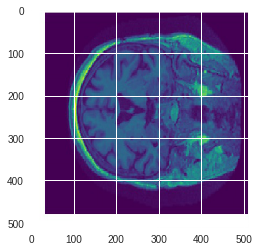

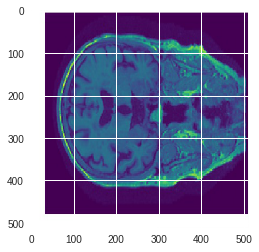

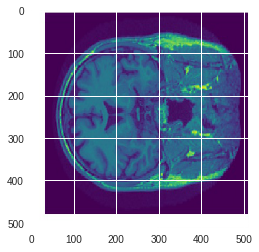

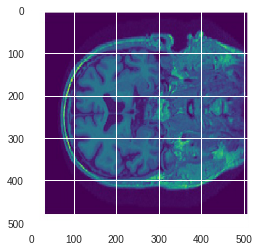

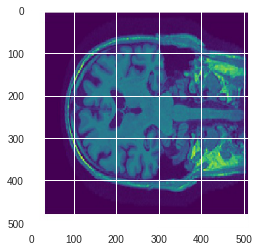

In [141]:
base='/content/test/images/CN'
li=os.listdir(base)
for image in li:
  im=plt.imread(os.path.join(base,image))
  im=transform.resize(im,(512,512))
  plt.imshow(im)
  plt.show()
  plt.imsave(os.path.join(base,image),im)